# Linear Regression

We can't do it manually all our life, let's try to automate it !

First with a naive and un-optimized idea try random a and b !

# Setup

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
import random
import matplotlib.colors as mcolors

import pickle

with open("Teach_linear_regression.pkl", "rb") as f:
    (
        x, y, COEF_A, COEF_B,
        COEF_A_MIN, COEF_A_MAX,
        COEF_B_MIN, COEF_B_MAX,
        WORST_A_PARAM, WORST_B_PARAM,
        MIN_COST, MAX_COST,
        MIN_VALUE, MAX_VALUE, NB_ELEMENTS,
    ) = pickle.load(f)

In [28]:
%matplotlib widget


def predict(x, thetas):
    a, b = thetas
    y_hat = (a * x) + b
    return y_hat


def get_cost(y, y_hat):
    return ((y - y_hat) ** 2).sum()


class Plot_linear_regression_3D:
    def __init__(self, fig, init_thetas, learning_rate = 0.01):
        random.seed(init_thetas[0] + init_thetas[1])
        self.thetas_history = []
        self.costs_history = []
        self.plot_objects = []  # List to store all plot objects

        self.fig = fig
        self.ax_2d = fig.add_subplot(1, 2, 1)
        self.ax_3d = fig.add_subplot(1, 2, 2, projection="3d")
        self.init_thetas = init_thetas
        self.thetas = init_thetas
        self.epsilon = 0.5
        self.learning_rate = learning_rate
        self.steps = 0
        self.coef_a = random.choice([-1, 1])
        self.coef_b = random.choice([-1, 1])
        self.set_epsilon_theta(self.thetas)

    def clear_plots(self):
        # Remove all stored plot objects
        for plot_obj in self.plot_objects:
            try:
                plot_obj.remove()
            except:
                # Some plot objects may be already removed or not have remove method
                print(f"Error removing plot object: {plot_obj}")
                import traceback
                traceback.print_exc()
                pass
        self.plot_objects = []
        self.thetas_history = []
        self.costs_history = []
        self.thetas = self.init_thetas
        self.set_epsilon_theta(self.thetas)

    def set_epsilon_theta(self, theta):
        random.seed(theta[0] + theta[1])
        self.theta = theta
        self.thetas_a_epsilon = self.thetas.copy()
        self.thetas_b_epsilon = self.thetas.copy()
        self.coef_a = random.choice([-1, 1])
        self.coef_b = random.choice([-1, 1])
        self.thetas_a_epsilon[0] = self.thetas_a_epsilon[0] + (self.epsilon * self.coef_a)
        self.thetas_b_epsilon[1] = self.thetas_b_epsilon[1] + (self.epsilon * self.coef_b)
        self.y_hat = predict(x, self.thetas)
        self.cost = get_cost(y, self.y_hat)
        self.y_hat_a = predict(x, self.thetas_a_epsilon)
        self.cost_a = get_cost(y, self.y_hat_a)
        self.y_hat_b = predict(x, self.thetas_b_epsilon)
        self.cost_b = get_cost(y, self.y_hat_b)

        self.d_cost_by_d_a = (self.cost_a - self.cost) * self.coef_a
        self.d_cost_by_d_b = (self.cost_b - self.cost) * self.coef_b

        self.d_cost_by_d_theta = np.array((self.d_cost_by_d_a, self.d_cost_by_d_b))
        self.next_thetas = self.thetas - (self.learning_rate * self.d_cost_by_d_theta)
        self.cost_next_thetas = get_cost(y, predict(x, self.next_thetas))

    def learn(self, steps):
        for i in range(steps):
            # print(f"{i = } begin {self.thetas = }")
            self.set_epsilon_theta(self.thetas)
            self.costs_history.append(self.cost)
            self.thetas_history.append(self.thetas)
            self.thetas = self.next_thetas
            self.steps = i + 1
            # print(f"{i = } end {self.thetas = }")

    def get_alpha(self, i, total):
        min_alpha = .2
        max_alpha = .6
        return np.linspace(min_alpha, max_alpha, total + 1)[i + 1]

    def plot_regressions(self, plot_epsilon=False):
        scatter = self.ax_2d.scatter(x, y, c="b", s=5, marker="+", zorder=1, label="Data")
        self.plot_objects.append(scatter)

        for i, thetas in enumerate(self.thetas_history):
            line = self.ax_2d.plot(x, predict(x, thetas), c='orange', alpha=self.get_alpha(i, len(self.thetas_history)))
            self.plot_objects.extend(line)

        self.set_epsilon_theta(self.thetas)
        # print(f"{self.thetas = }")
        line = self.ax_2d.plot(
            x, 
            self.y_hat, 
            c="r", 
            label="Linear Regression : AX + B"
        )
        self.plot_objects.extend(line)

        if plot_epsilon:
            self.set_epsilon_theta(self.theta)
            line_a = self.ax_2d.plot(
                x,
                self.y_hat_a, 
                c="grey", 
                linestyle="--",
                label="$ dA = A + \epsilon $",
            )
            line_b = self.ax_2d.plot(
                x,
                self.y_hat_b, 
                c="grey", 
                linestyle=":",
                label="$ dB = B + \epsilon $",
            )
            self.plot_objects.extend(line_a)
            self.plot_objects.extend(line_b)

        self.ax_2d.set_xlabel("X")
        self.ax_2d.set_ylabel("Y")
        self.ax_2d.set_title(f"All linear regressions")
        self.ax_2d.legend()

    def plot_cost_3d_epsilon_lines(self, plot_next_thetas=False):
        scatter_a = self.ax_3d.scatter(
            self.thetas_a_epsilon[0],
            self.thetas_a_epsilon[1],
            zs=self.cost_a,
            c="grey",
            marker="x",
            label=f"$ \\text{{loss}}(dA X + B) = {self.cost_a:.2f} $",
        )
        self.plot_objects.append(scatter_a)

        # line_a = self.ax_3d.plot(
        #     (self.thetas[0], self.thetas_a_epsilon[0]),
        #     (self.thetas[1], self.thetas_a_epsilon[1]),
        #     (self.cost, self.cost_a),
        #     c="magenta",
        #     linestyle="--",
        # )
        # self.plot_objects.extend(line_a)

        scatter_b = self.ax_3d.scatter(
            self.thetas_b_epsilon[0],
            self.thetas_b_epsilon[1],
            zs=self.cost_b,
            c="grey",
            marker="+",
            label=f"$ \\text{{loss}}(A X + dB) = {self.cost_b:.2f} $",
        )
        self.plot_objects.append(scatter_b)

        # line_b = self.ax_3d.plot(
        #     (self.thetas[0], self.thetas_b_epsilon[0]),
        #     (self.thetas[1], self.thetas_b_epsilon[1]),
        #     (self.cost, self.cost_b),
        #     c="magenta",
        #     linestyle=":",
        # )
        # self.plot_objects.extend(line_b)

        x = np.array([self.thetas[0], self.thetas_a_epsilon[0], self.thetas_b_epsilon[0]])
        y = np.array([self.thetas[1], self.thetas_a_epsilon[1], self.thetas_b_epsilon[1]])
        z = np.array([self.cost, self.cost_a, self.cost_b])
        surface = self.ax_3d.plot_trisurf(
            x, y, z, 
            linewidth=0.2, 
            antialiased=True,
            alpha=.5,
            color="grey",
        )
        self.plot_objects.append(surface)

        if plot_next_thetas:            
            # self.d_cost_by_d_a = (self.cost_a - self.cost) * self.coef_a
            # self.d_cost_by_d_b = (self.cost_b - self.cost) * self.coef_b
            line_next = self.ax_3d.plot(
                (self.thetas[0], self.next_thetas[0]),
                (self.thetas[1], self.next_thetas[1]),
                (self.cost, self.cost_next_thetas),
                c="blue",
                label=(
                    r"$ A = A - (\frac{d\text{loss}}{dA} \times \alpha)$" 
                    + "\n" 
                    + r"$ B = B - (\frac{d\text{loss}}{dB} \times \alpha)$"
                ),
                alpha = 1,
            )
            self.plot_objects.extend(line_next)
        # self.ax_3d.legend()
        
    def plot_vertical_lines(self):
        # Plot vertical lines for epsilon points
        # z_min, z_max = self.ax_3d.get_zlim()
        z_min, z_max = min(0, MIN_COST) -10, MAX_COST + 10
        
        line_a_vertical = self.ax_3d.plot(
            [self.thetas_a_epsilon[0], self.thetas_a_epsilon[0]],
            [self.thetas_a_epsilon[1], self.thetas_a_epsilon[1]], 
            [z_min, z_max],
            c="grey",
            linestyle="--",
            # alpha=0.5
            label="$ dA = A + \epsilon $",
        )
        self.plot_objects.extend(line_a_vertical)

        line_b_vertical = self.ax_3d.plot(
            [self.thetas_b_epsilon[0], self.thetas_b_epsilon[0]],
            [self.thetas_b_epsilon[1], self.thetas_b_epsilon[1]],
            [z_min, z_max],
            c="grey",
            linestyle=":",
            label="$ dB = B + \epsilon $",
            # alpha=0.5
        )
        self.plot_objects.extend(line_b_vertical)
        
        line = self.ax_3d.plot(
            (self.thetas[0], self.thetas[0]),
            (self.thetas[1], self.thetas[1]),
            (z_min, z_max),
            c="red",
            linestyle="-",
            alpha=0.5,
        )[0]
        self.plot_objects.append(line)
    
    def plot_cost_3d(self, plot_epsilon=False, plot_next_thetas=False, plot_vertical_lines=False, zoom_on_plane=False, legend_3d=True):
        previous_cost = 0
        previous_thetas = None
        for i, ((theta_a, theta_b), cost) in enumerate(zip(
            self.thetas_history, 
            self.costs_history
        )):
            scatter = self.ax_3d.scatter(
                theta_a,
                theta_b,
                zs=cost,
                c='orange',
                alpha=self.get_alpha(i, len(self.thetas_history))
            )
            self.plot_objects.append(scatter)

            if previous_thetas is not None:
                line = self.ax_3d.plot(
                    (previous_thetas[0], theta_a),
                    (previous_thetas[1], theta_b),
                    (previous_cost, cost),
                    c="orange",
                    alpha=self.get_alpha(i, len(self.thetas_history)),
                )
                self.plot_objects.extend(line)
            previous_cost = cost
            previous_thetas = (theta_a, theta_b)

        if len(self.thetas_history) > 0:
            line = self.ax_3d.plot(
                (previous_thetas[0], self.thetas[0]),
                (previous_thetas[1], self.thetas[1]),
                (previous_cost, self.cost),
                c="orange",
                # alpha=self.get_alpha(i, len(self.thetas_history)),
            )
            self.plot_objects.extend(line)
        
        scatter = self.ax_3d.scatter(
            self.thetas[0],
            self.thetas[1],
            zs=self.cost,
            c="red",
            label="AX + B",
        )
        self.plot_objects.append(scatter)
        
        if plot_vertical_lines:
            self.plot_vertical_lines()
        if plot_epsilon:
            self.plot_cost_3d_epsilon_lines(plot_next_thetas=plot_next_thetas)

        if zoom_on_plane:
            padding = 0.1
            self.ax_3d.set_xlim(
                min(self.thetas[0], self.thetas_a_epsilon[0], self.thetas_b_epsilon[0], self.next_thetas[0]) - padding, 
                max(self.thetas[0], self.thetas_a_epsilon[0], self.thetas_b_epsilon[0], self.next_thetas[0]) + padding
            )
            self.ax_3d.set_ylim(
                min(self.thetas[1], self.thetas_a_epsilon[1], self.thetas_b_epsilon[1], self.next_thetas[1]) - padding, 
                max(self.thetas[1], self.thetas_a_epsilon[1], self.thetas_b_epsilon[1], self.next_thetas[1]) + padding
            )
            self.ax_3d.set_zlim(
                min(self.cost, self.cost_a, self.cost_b, self.cost_next_thetas) - padding, 
                max(self.cost, self.cost_a, self.cost_b, self.cost_next_thetas) + padding
            )
        else:
            self.ax_3d.set_xlim(COEF_A_MIN, COEF_A_MAX)
            self.ax_3d.set_ylim(COEF_B_MIN, COEF_B_MAX)
            self.ax_3d.set_zlim(0, MAX_COST)
        self.fig.suptitle(f"Steps: {self.steps} with cost: {self.cost:.2f}")
        self.ax_3d.set_xlabel("LR parameter a")
        self.ax_3d.set_ylabel("LR parameter b")
        self.ax_3d.set_zlabel("LR total error")
        self.ax_3d.set_title("Error in function of parameters a and b of LR")
        if legend_3d:
            self.ax_3d.legend()
        else:
            self.ax_3d.get_legend().remove()


a = (random.random() - COEF_A_MIN) * COEF_A_MAX
b = (random.random() - COEF_B_MIN) * COEF_B_MAX
a = WORST_A_PARAM
b = WORST_B_PARAM


# Teach

interactive(children=(ToggleButtons(description='Steps:', options=(0, 1, 2, 4, 8, 16, 32, 64, 128), value=0), …

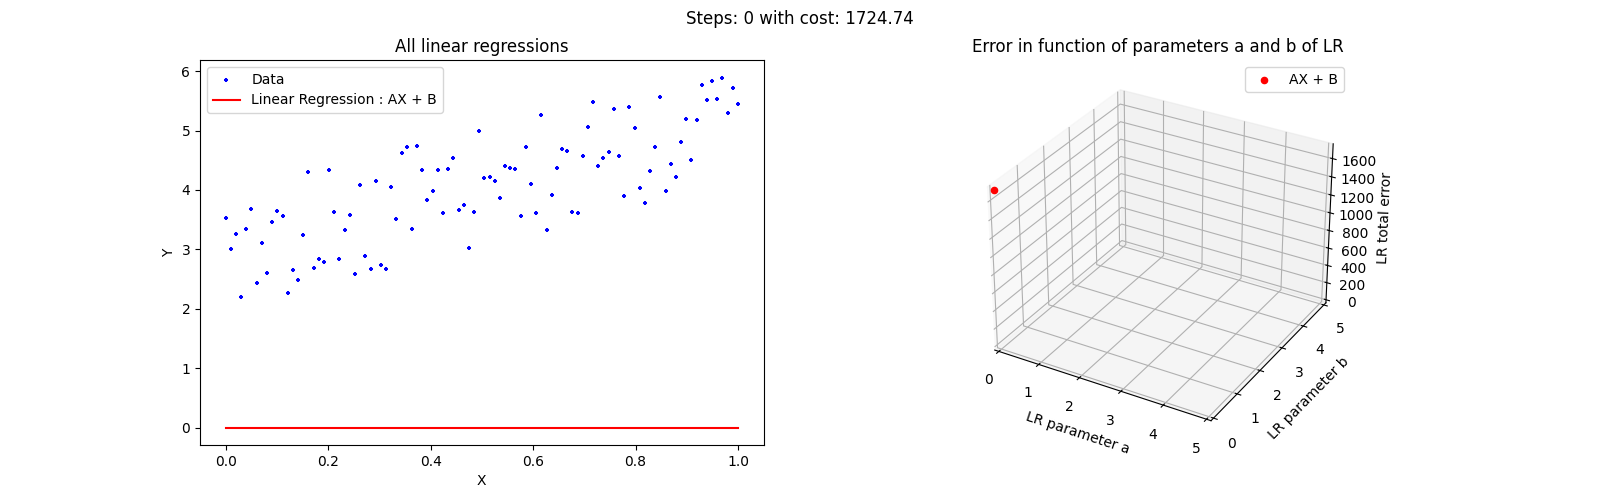

In [29]:
fig = plt.figure(figsize=(16, 5))
learning_rate = 1e-3
a = WORST_A_PARAM
b = WORST_B_PARAM
thetas = np.array((a, b))
plr = Plot_linear_regression_3D(fig, thetas, learning_rate=learning_rate)
@interact(
    steps=widgets.ToggleButtons(
        options=[0] + [2**i for i in range(8)],
        description="Steps:",
        disabled=False,
        button_style="",
    ),
    visualisation_option=widgets.ToggleButtons(
        options=["Base LR", "Params + ε", "Finite Difference", "Next update ?"],
        description="Visualisation:",
        disabled=False,
        button_style="",
    ),
    zoom_on_plane=widgets.Checkbox(value=False, description="Zoom on plane"),
    legend_3d=widgets.Checkbox(value=True, description="3D legend"),
)
def interactive_linear_regression(steps, visualisation_option, zoom_on_plane, legend_3d):
    plr.clear_plots()
    plr.learn(steps)
    if visualisation_option == "Base LR":
        plot_epsilon_regression = False
        plot_epsilon_cost = False
        plot_next_thetas = False
        plot_vertical_lines = False
    elif visualisation_option == "Params + ε":
        plot_epsilon_regression = True
        plot_epsilon_cost = False
        plot_next_thetas = False
        plot_vertical_lines = True
    elif visualisation_option == "Finite Difference":
        plot_epsilon_regression = True
        plot_epsilon_cost = True
        plot_next_thetas = False
        plot_vertical_lines = True
    elif visualisation_option == "Next update ?":
        plot_epsilon_regression = True
        plot_epsilon_cost = True
        plot_next_thetas = True
        plot_vertical_lines = True
    plr.plot_regressions(plot_epsilon=plot_epsilon_regression)
    plr.plot_cost_3d(
        plot_epsilon=plot_epsilon_cost, 
        plot_next_thetas=plot_next_thetas, 
        plot_vertical_lines=plot_vertical_lines,
        zoom_on_plane=zoom_on_plane,
        legend_3d=legend_3d,
    )

# Predict

$$
\hat{y} = ax + b
$$



## Finite difference method

![](./data/finite_difference.png)



### Conclusion

It works, but...

- It's an approximation
- It is quite costly in compute (3 inferences per step, for A&B, (A+ε & B), (B+ε & A))

Let's shift to a more analytical approach !